In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly

from pathlib import Path
from ast import literal_eval
from tqdm import tqdm
from scipy.stats import entropy

In [2]:
DATA_PATH = Path("../data")  # specify data directory

# Load data

In [3]:
dbs = ['afdb_light', 'afdb_dark', 'mip', 'esm']

In [4]:
taxonomy = {}
for db in dbs:
    taxonomy[db] = pd.read_parquet(DATA_PATH / f"{db}_taxonomy.parquet")
    if db != 'esm':
        # rename Unassigned to Unknown since it is very rare category
        taxonomy[db]['division_name'] = taxonomy[db]['division_name'].str.replace("Unassigned", "Unknown")

### High-quality AFDB proteins

In [5]:
afdb_hq = pd.read_csv(DATA_PATH / 'intermediate' / 'afdb_hq.csv')
afdb_hq = afdb_hq[afdb_hq.globalMetricValue >= 70].name.values

### All clusters

In [6]:
all_clusters = pd.read_csv(DATA_PATH / 'intermediate' / 'all_clusters.csv')
all_clusters['Protein'] = all_clusters['Protein'].apply(lambda x: literal_eval(str(x)))

### High-quality cluster identifiers

In [7]:
heterogeneity_hq = pd.read_parquet(DATA_PATH / 'heterogeneity_hq.parquet')
heterogeneity_hq['counts_total'] = heterogeneity_hq.sum(axis=1)
heterogeneity_hq['prop_esm'] = heterogeneity_hq['counts_esmatlas'] / heterogeneity_hq['counts_total']

### Preprocess ESM biomes

In [8]:
taxonomy['esm']['biome_category'] = taxonomy['esm'].biome.str.split(':').apply(lambda x: ', '.join(x[1:3])).str.replace(',root', '')
taxonomy['esm']['biome_category'] = taxonomy['esm']['biome_category'].replace('', 'Unknown')

In [9]:
esm_categories = taxonomy['esm']['biome_category'].value_counts().to_frame().reset_index()

In [10]:
# Merge small categories into "Other"
threshold = 20_000
esm_categories['main_category'] = esm_categories['biome_category'].str.split(', ').str[0]  # Extract main category
# Mark categories to be merged
esm_categories['biome_category'] = esm_categories.apply(
    lambda row: f"{row['main_category']}, Other" if row['count'] < threshold else row['biome_category'],
    axis=1)
# Sum counts for new categories
esm_categories = esm_categories.groupby('biome_category', as_index=False)['count'].sum()
# Drop the extra column
esm_categories = esm_categories.drop(columns=['main_category'], errors='ignore')
# Replace `Unkown, Other` category to the original name
esm_categories.loc[esm_categories['biome_category'] == 'Unknown, Other', 'biome_category'] = 'Unknown'
# Sort values
esm_categories = esm_categories.sort_values(by="count", ascending=False)

# Basic taxonomic categories

In [11]:
taxonomy['afdb_dark'].division_name.value_counts()#normalize=True)

division_name
Bacteria                 418377
Plants and Fungi         169777
Invertebrates             87467
Environmental samples     18003
Vertebrates               10117
Unknown                    4040
Mammals                    2623
Primates                    697
Rodents                     604
Name: count, dtype: int64

In [12]:
taxonomy['afdb_light'].division_name.value_counts()#normalize=True)

division_name
Bacteria                 788758
Plants and Fungi         413705
Invertebrates            264923
Vertebrates               59231
Environmental samples     29724
Mammals                   18077
Unknown                    7368
Rodents                    4711
Primates                   4703
Phages                        3
Name: count, dtype: int64

In [13]:
taxonomy['mip'].division_name.value_counts()

division_name
Bacteria    208091
Unknown       2978
Name: count, dtype: int64

In [14]:
esm_categories.sort_values('count', ascending=False)

,biome_category,count
4,"Environmental, Aquatic",787222
3,"Engineered, Wastewater",186974
7,"Host-associated, Human",127475
11,Mixed,124283
0,"Engineered, Bioreactor",85900
10,"Host-associated, Plants",71085
6,"Environmental, Terrestrial",64533
2,"Engineered, Other",61154
8,"Host-associated, Mammals",47787
1,"Engineered, Bioremediation",31302


#
---
# Plots
---

# Figure 6 (panels A, B)
## AFDB + MIP

In [15]:
dfs = {}
for db in dbs[:-1]:  # exclude ESMAtlas
    dfs[db] = taxonomy[db].division_name.value_counts().to_frame()
    dfs[db] = dfs[db].groupby(dfs[db].index).sum().sort_values('count', ascending=False)

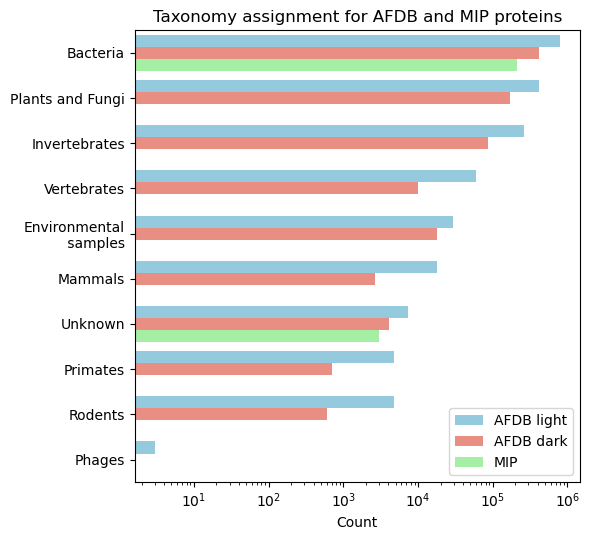

In [16]:
long_df_list = []

for dataset_name, df in dfs.items():
    temp = df.reset_index()  # Ensure category names are preserved
    if 'Category' not in temp.columns:
        temp = temp.rename(columns={temp.columns[0]: 'Category'})  # Rename first column to 'Category' if unnamed
    temp['Dataset'] = dataset_name
    long_df_list.append(temp)

# Combine all dataframes
combined_df = pd.concat(long_df_list, ignore_index=True)

# Preserve Dataset order as in dfs
dataset_order = list(dfs.keys())
combined_df['Dataset'] = pd.Categorical(
    combined_df['Dataset'],
    categories=dataset_order,
    ordered=True
)

# Category order by total count
category_order = (
    combined_df.groupby('Category', observed=True)['count']
    .sum()
    .sort_values(ascending=False)
    .index
)

combined_df['Category'] = pd.Categorical(
    combined_df['Category'],
    categories=category_order,
    ordered=True
)

label_map = {
    "afdb_light": "AFDB light",
    "afdb_dark": "AFDB dark",
    "mip": "MIP"
}

custom_palette = {
    "AFDB dark": "salmon",
    "AFDB light": "skyblue",
    "MIP": "#98FB98"
}

combined_df['Dataset'] = combined_df['Dataset'].map(label_map)
combined_df['Category'] = combined_df['Category'].cat.rename_categories(
    lambda x: 'Environmental\n samples' if x == 'Environmental samples' else x
)
plt.figure(figsize=(6, 5.5))
g = sns.barplot(
    data=combined_df,
    x="count", y="Category",
    hue="Dataset", orient="h", dodge=True,
    palette=custom_palette,
)
g.legend_.set_title(None)
plt.title("Taxonomy assignment for AFDB and MIP proteins", fontsize=12)
plt.xscale("log")
plt.xlabel("Count")
plt.ylabel("")
plt.tight_layout()
plt.show()

## ESMAtlas biomes

In [17]:
# Create a DataFrame with hierarchical split  
esm_categories[['Main', 'Sub']] = esm_categories['biome_category'].str.split(', ', n=1, expand=True).fillna('')  

# Create Sunburst chart  
fig = px.sunburst(  
    esm_categories,   
    path=['Main', 'Sub'],   
    values='count',   
    color='Main',  # Color by main category  
    color_discrete_sequence=px.colors.qualitative.Set3,  
)  

# Define threshold for "small" slices (e.g., 1%)  
threshold = 0.01  # Adjust as needed  
# Calculate total for percentage calculations  
total = esm_categories['count'].sum()

# Create a list of dictionaries for updating the text appearance  
# We'll make text invisible for small slices by setting the color to 'rgba(0,0,0,0)'  
custom_colors = []  
for i, value in enumerate(fig.data[0].values):  
    percentage = value / total  
    if percentage < threshold:  
        custom_colors.append('rgba(0,0,0,0)')  
    else:  
        custom_colors.append('black') 

# Update the trace with custom text colors  
fig.update_traces(  
    textinfo="label+percent entry",  
    textfont=dict(  
        size=14,  
        color=custom_colors  
    )  
)  

# Manual curation - rare categories are not visible  
annotations = [  
    dict(  
        x=0.71,  # Adjust the x, y position as needed  
        y=0.48,   
        text="Unknown <br> 0.7%",  # Label text (read from dataframe)  <------------ !!!
        showarrow=False,  
        font=dict(size=10, color="black"),  
        align="center"  
    ),  
    dict(  
        x=0.29,  # Adjust the x, y position as needed  
        y=0.43,  
        text="Other <br> 0.3%",  # Label text (read from dataframe)   <------------ !!!
        showarrow=False,  
        font=dict(size=10, color="black"),  
        align="center"  
    ),  
]  
fig.update_layout(
    title=dict(
        text="Biome assignment for ESMAtlas proteins",
        x=0.5,
        xanchor='center',
        font=dict(size=19)
    ),
    annotations=annotations
)
plotly.offline.plot(fig, filename='esm_biomes.html')  

'esm_biomes.html'

# Supplementary plots

## Difference between taxonomy of dark and light AFDB proteins

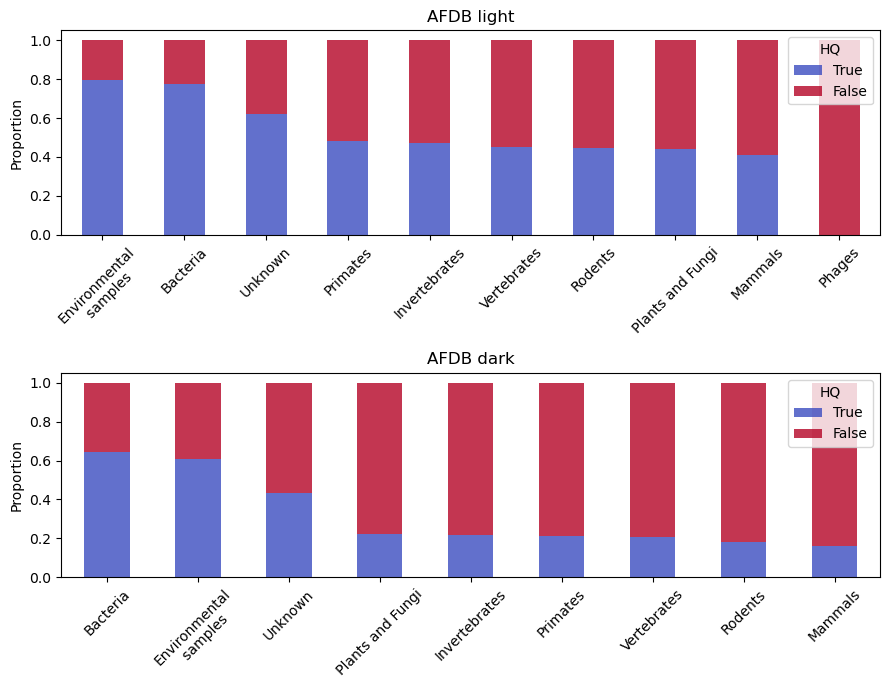

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(9, 7))
for i, (db, lab) in enumerate(zip(['afdb_light', 'afdb_dark'], 
                                  ['AFDB light', 'AFDB dark'])):
    # Assign quality
    taxonomy[db]['HQ'] = 'False'
    taxonomy[db].loc[taxonomy[db].index.isin(afdb_hq), 'HQ'] = 'True'
    # Group and count
    grouped = taxonomy[db].groupby(['division_name', 'HQ']).size().unstack(fill_value=0)
    grouped.index = grouped.index.str.replace('Environmental samples', 
                                              'Environmental\n samples')
    # Normalize per division_name
    grouped_norm = grouped.div(grouped.sum(axis=1), axis=0)
    grouped_norm = grouped_norm[['True', 'False']] 
    # Calculate proportion of HQ=True for each division_name
    hq_true_proportions = grouped_norm['True']
    # Sort the division_name based on the proportion of HQ=True
    sorted_divisions = hq_true_proportions.sort_values(ascending=False).index
    # Reorder the DataFrame based on sorted divisions
    grouped_norm = grouped_norm.loc[sorted_divisions]
    # Plot stacked bar chart
    grouped_norm.plot(kind='bar', stacked=True, alpha=0.8,
                      ax=ax[i], colormap='coolwarm')
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Proportion')
    ax[i].set_title(lab)
    ax[i].tick_params(axis='x', labelrotation=45)
    ax[i].legend(title='HQ')
plt.tight_layout()
plt.show()

## Prokaryotic content in heterogeneous clusters

#### Add taxonomy for AFDB HQ and MIP

In [19]:
all_clusters_exp = all_clusters.explode('Protein')
taxonomy_afdb_mip = pd.concat([
    taxonomy['afdb_dark'][taxonomy['afdb_dark'].index.isin(afdb_hq)],
    taxonomy['afdb_light'][taxonomy['afdb_light'].index.isin(afdb_hq)],
    taxonomy['mip'].drop(columns=['reference'])])
all_clusters_exp = all_clusters_exp.join(taxonomy_afdb_mip, on='Protein')

### Compute prokaryotic proportion in clusters

In [20]:
prokaryotic  = (
    all_clusters_exp.dropna()
    .assign(is_prok=lambda df: df['division_group'] == 'Prokaryote')
    .groupby('Cluster')['is_prok']
    .agg(prop_prokaryotic='mean')
)

In [21]:
hetero_clusts = heterogeneity_hq.query('counts_total >= 10 and prop_esm < 0.3')
# hetero_clusts = heterogeneity_hq.query('counts_total >= 10 and prop_esm > 0.7')
hetero_clusts = hetero_clusts.join(prokaryotic, how='inner')

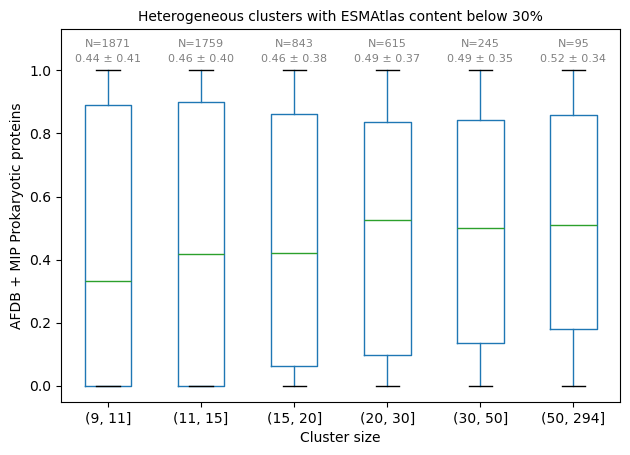

In [22]:
# Bin the data
hetero_clusts['size_bin'] = pd.cut(
    hetero_clusts['counts_total'], 
    bins=[
        hetero_clusts['counts_total'].min()-1, 11, 15, 20, 30, 50, 
        hetero_clusts['counts_total'].max()
    ]
)

# Create the boxplot
ax = hetero_clusts.boxplot(
    column='prop_prokaryotic', 
    by='size_bin', 
    grid=False
)

# Customize plot
plt.title(r'Heterogeneous clusters with ESMAtlas content below 30%', fontsize=10)
# plt.title(r'Heterogeneous clusters with ESMAtlas content above 70%', fontsize=10)
plt.suptitle('')
plt.ylim(-0.05, 1.13)
plt.xlabel('Cluster size')
plt.ylabel('AFDB + MIP Prokaryotic proteins')
plt.tight_layout()

# Get the xtick labels and positions
xticks = ax.get_xticks()
xticklabels = [tick.get_text() for tick in ax.get_xticklabels()]

# Annotate with mean ± std and number of points
for i, label in enumerate(xticklabels):
    bin_data = hetero_clusts[hetero_clusts['size_bin'].astype(str) == label]['prop_prokaryotic']
    if not bin_data.empty:
        mean = bin_data.mean()
        std = bin_data.std()
        count = bin_data.count()

        # Place mean ± std above the box
        ax.text(
            xticks[i], 
            bin_data.max() + 0.02,  # adjust height if necessary
            f'{mean:.2f} ± {std:.2f}', 
            ha='center', 
            va='bottom', 
            fontsize=8, 
            color='gray'
        )

        # Place count below the x-axis tick
        ax.text(
            xticks[i], 
            ax.get_ylim()[1] - 0.03,  # slightly below min y
            f'N={count}', 
            ha='center', 
            va='top', 
            fontsize=8, 
            color='gray'
        )
plt.show()

# Figure 6C
## Clusters with the largest taxonomic diversity

In [23]:
hetero_large = heterogeneity_hq.query('counts_total >= 100')

In [24]:
hetero_large['entropy'] = np.nan
tax_groups_dict = {}
for i, row in tqdm(hetero_large.iterrows(), total=len(hetero_large)):
    cluster = row.name
    proteins = all_clusters[all_clusters.Cluster == cluster].Protein.values[0]
    tax_groups = {}
    for k in ['afdb_light', 'afdb_dark']:
        taxs = taxonomy[k][taxonomy[k].index.isin(proteins)]
        taxs = taxs[taxs.index.isin(afdb_hq)]
        tax_groups[k] = taxs.division_name.value_counts()
    tax_groups = pd.concat(tax_groups)
    tax_groups_dict[cluster] = tax_groups
    hetero_large.loc[cluster, 'entropy'] = entropy(tax_groups.values)

/tmp/ipykernel_462096/3771073614.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [03:37<00:00,  1.89it/s]


In [25]:
hetero_large.sort_values('entropy', ascending=False)[:20]

,counts_afdb_light,counts_afdb_dark,counts_esmatlas,counts_mip_clusters,counts_mip_singletons,counts_total,prop_esm,entropy
protein,,,,,,,,
MGYP000855844059,19,1,103,0,0,123,0.837398,1.565731
MGYP002168801071,19,0,144,0,0,163,0.883436,1.559087
MGYP003387535279,55,0,78,0,0,133,0.586466,1.545622
MGYP001416922367,71,1,71,0,0,143,0.496503,1.502733
MGYP001180411849,55,0,60,0,0,115,0.521739,1.485241
A0A409XNK1,32,0,92,0,0,124,0.741935,1.479065
MGYP003352392766,30,0,88,0,0,118,0.745763,1.477087
U6GJL0,97,0,48,0,0,145,0.331034,1.454521
MGYP000172718835,64,0,105,0,0,169,0.621302,1.422992
